# Credit Card Default Demo

In [32]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model
from recourse_methods import mrmc_method, dice_method
from core import recourse_iterator
from data import data_loader
from data.adapters import continuous_adapter
from core import utils
from models import model_interface
from visualize.two_d_plots import Display2DPaths

## Load the data and model

In [7]:
dataset, dataset_info = data_loader.load_data(data_loader.DatasetName.CREDIT_CARD_DEFAULT)
adapter = continuous_adapter.StandardizingAdapter(column_label=dataset_info.column_label, positive_label=dataset_info.positive_label).fit(dataset)
dataset

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,689,0,0,0,0,1
2,120000,26,0,2,0,0,0,2,2682,1725,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,57,0,0,0,0,0,0,8617,5670,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,43,0,0,0,0,0,0,1683,1828,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,37,4,3,2,0,0,0,3565,3356,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


Accuracy:  0.8186333333333333


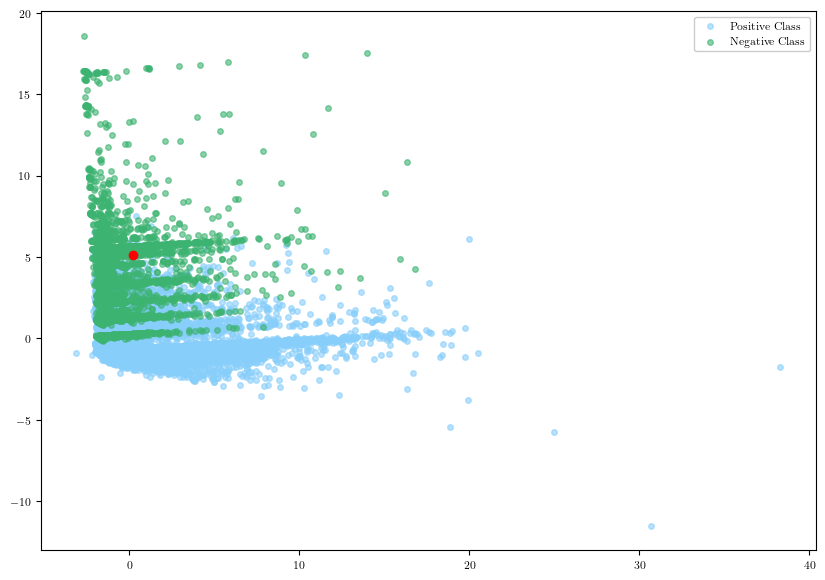

In [27]:
embedded_dataset = adapter.transform(dataset)
X = embedded_dataset.drop(dataset_info.column_label, axis=1)
y = embedded_dataset[dataset_info.column_label]

lr = linear_model.LogisticRegression(penalty='none')
lr.fit(X, y)

model = model_interface.SKLearnModel(lr, adapter)
y_pred = model.predict(dataset)
print("Accuracy: ", (dataset[dataset_info.column_label] == y_pred).sum() / y.size)

dataset[dataset_info.column_label] = model.predict(dataset)

poi = utils.random_poi(dataset, label_column='Y', label_value=adapter.negative_label)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label = dataset_info.positive_label,
).set_poi(adapter.transform_series(poi)).do_pca().scatter()

## Generate some recourse directions

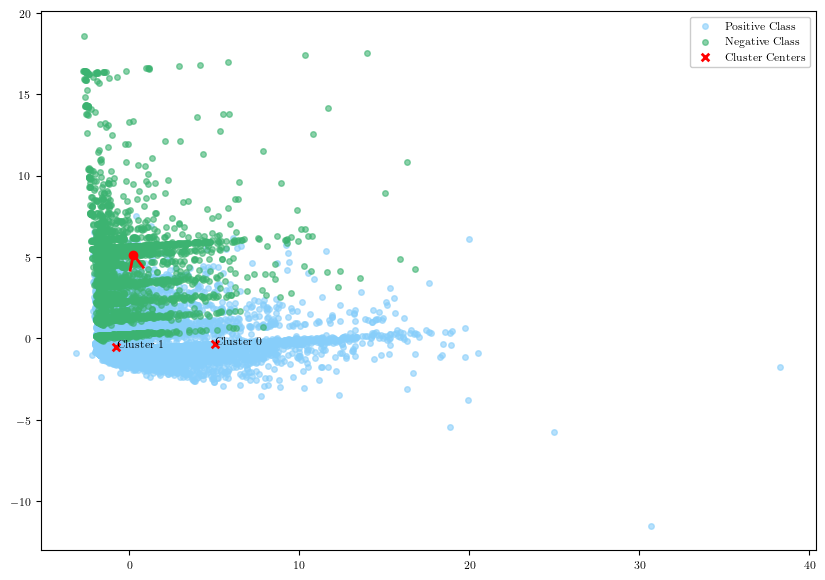

In [28]:
k_directions = 2
mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(1))
poix = adapter.transform_series(poi)
dirs = mrmc.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
).do_pca().set_poi(poix).set_dirs(dirs, poix).set_clusters(mrmc.clusters.cluster_centers).scatter()

## Generate some paths

final certainty for path 0: 0.5202951405632739
final certainty for path 1: 0.5036050326415081


(<Figure size 1000x700 with 1 Axes>, <AxesSubplot:>)

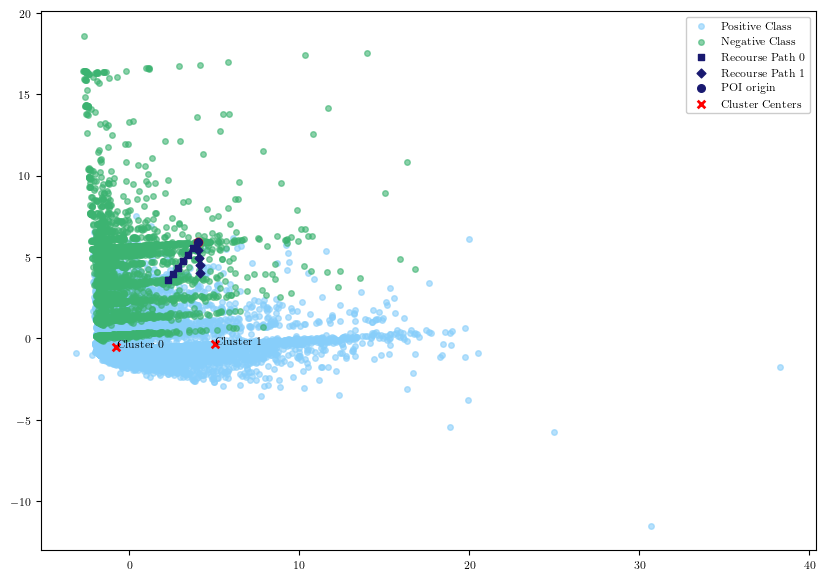

In [29]:
mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.5))

display = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label
)

poi = utils.random_poi(dataset, label_column='Y', label_value = 1)

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    adapter,
    certainty_cutoff=0.5,
    model=model)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {model.predict_pos_proba_series(path.iloc[-1])}')

transformed_paths = [adapter.transform(path) for path in paths]

display.do_pca().set_poi(adapter.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).scatter()

## What features are changed?

In [30]:
paths[0]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,180000.000000,23.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,157074.000000,158088.000000,166492.000000,168487.000000,172662.000000,172027.000000,5000.000000,12552.000000,6200.000000,7000.000000,2304.000000,6180.000000
1,178356.343231,23.730941,1.885656,1.887617,1.888417,1.886134,1.884031,1.884823,149304.253272,150119.338170,157879.547372,159578.337432,163369.961468,162714.738782,4942.563203,12033.806825,6046.464435,6780.037101,2370.127714,6021.500399
2,176685.773915,24.460342,1.771248,1.775192,1.776770,1.772203,1.767997,1.769581,141542.690996,142158.595287,149274.073765,150675.392509,154082.122011,153405.841873,4883.778221,11513.890756,5891.340756,6558.220502,2434.592422,5860.510089
3,174984.509718,25.187797,1.656771,1.662706,1.665029,1.658174,1.651873,1.654250,133791.723428,134208.105696,140677.815609,141780.203195,144800.310720,144102.010411,4823.392639,10992.012505,5734.356120,6334.252847,2497.112639,5696.660787
4,173248.306028,25.912763,1.542225,1.550136,1.553150,1.544005,1.535619,1.538798,126054.614185,126271.027635,132093.838942,132895.607620,135527.142113,134805.706589,4761.098860,10467.913000,5575.188923,6107.790201,2557.345864,5529.525511
5,171472.478093,26.634506,1.427615,1.437444,1.441072,1.429633,1.419181,1.423179,118335.786370,118351.638740,123526.348680,124025.555682,126266.341603,125520.475057,4696.520604,9941.321003,5413.461113,5878.437748,2614.870456,5358.609834
6,169651.927377,27.352028,1.312948,1.324576,1.328707,1.314967,1.302483,1.307334,110641.197391,110455.699970,114981.075187,115175.504896,117023.166287,116251.361880,4629.194922,9411.963217,5248.727935,5645.743539,2669.160011,5183.339476


In [31]:
paths[1]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,180000.000000,23.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,157074.000000,158088.000000,166492.000000,168487.000000,172662.000000,172027.000000,5000.000000,12552.000000,6200.000000,7000.000000,2304.000000,6180.000000
1,185998.992094,24.044173,1.851366,1.852484,1.853390,1.852908,1.851665,1.852351,159110.255680,159738.284625,167021.683125,167936.153712,170944.959049,169920.675293,5491.633822,12468.732495,6470.942895,7139.887387,2815.289542,6375.803414
2,191881.095924,25.084225,1.702688,1.704925,1.706668,1.705637,1.703159,1.704573,161099.784060,161338.856837,167499.823443,167340.460092,169188.890884,167781.283275,5964.286816,12363.089291,6724.263327,7264.464719,3312.292511,6555.497226
3,197620.291028,26.117878,1.554153,1.557334,1.559757,1.558075,1.554382,1.556621,163031.125100,162878.069694,167914.856710,166690.760021,167386.053128,165601.659296,6415.363248,12231.863843,6958.215046,7371.242240,3792.208106,6717.595237
4,203186.283072,27.142435,1.405949,1.409738,1.412561,1.410098,1.405222,1.408459,164891.343669,164342.484874,168254.255692,165977.263779,165529.082728,163375.239889,6841.439709,12071.847840,7170.308030,7457.745673,4251.847814,6860.063923


# Now try DiCE

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


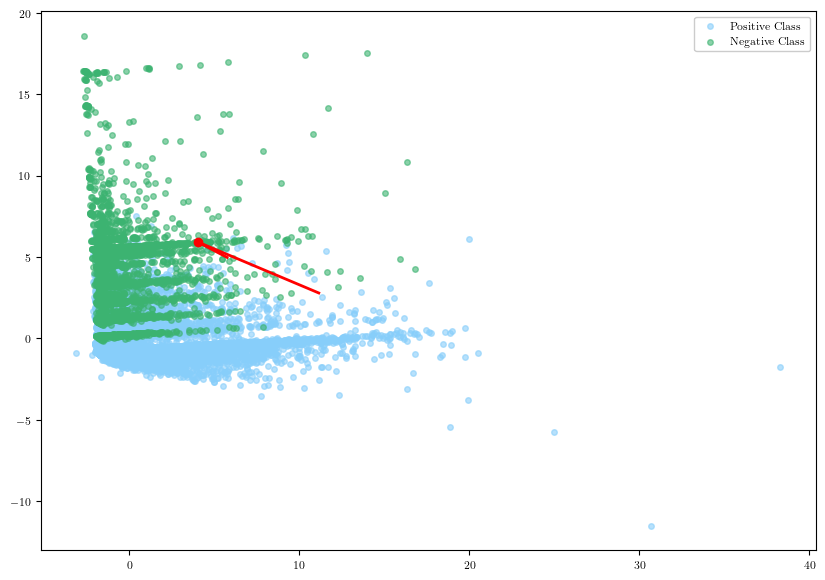

In [40]:
k_directions = 2
dice = dice_method.DiCE(
    k_directions,
    adapter,
    dataset,
    continuous_features=dataset_info.continuous_features,
    model=model,
    desired_confidence=0.5)

poix = adapter.transform_series(poi)
dirs = dice.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
).do_pca().set_poi(poix).set_dirs(dirs, poix).scatter()

100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


final certainty for path 0: 0.5017107840484756
final certainty for path 1: 0.9142361571808505


(<Figure size 1000x700 with 1 Axes>, <AxesSubplot:>)

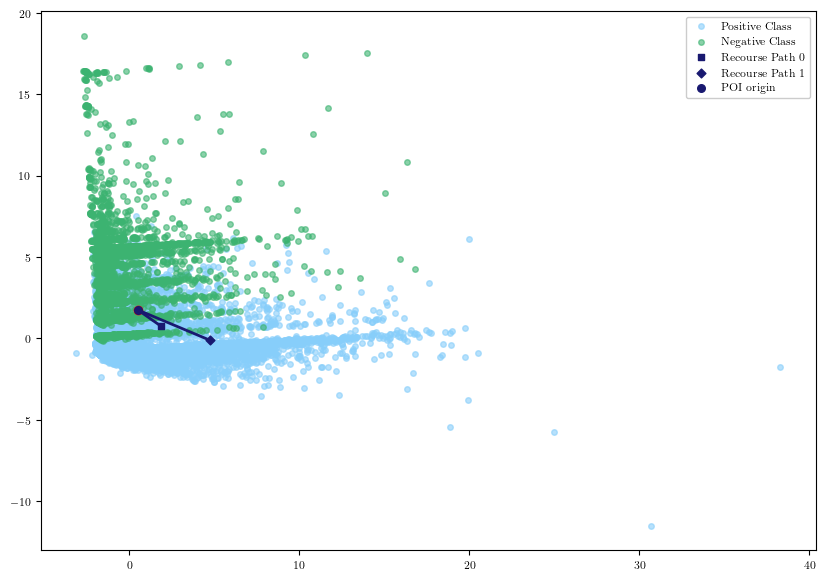

In [42]:
dice = dice_method.DiCE(
    k_directions,
    adapter,
    dataset,
    continuous_features=dataset_info.continuous_features,
    model=model,
    desired_confidence=0.5)

display = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label
)

poi = utils.random_poi(dataset, column_column='Y', label_value = 1)

iterator = recourse_iterator.RecourseIterator(
    dice,
    adapter,
    certainty_cutoff=0.5,
    model=model)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {model.predict_pos_proba_series(path.iloc[-1])}')

transformed_paths = [adapter.transform(path) for path in paths]

display.do_pca().set_poi(adapter.transform_series(poi)).set_paths(transformed_paths).scatter()